In [1]:
import numpy as np

I'll start by loading the available images. They are only four, so I'll load each of them as it's easier to manage them like that.

In [2]:
from pathlib import Path

basedir = Path("..")

pos_mean_mri = np.load(basedir / 'pos_mean_mri.npy')
pos_mean_pet = np.load(basedir / 'pos_mean_pet.npy')
resized_neg_mri = np.load(basedir / 'resized_neg_mri.npy')
resized_pos_mri = np.load(basedir / 'resized_pos_mri.npy')

I'll try to plot a slice of the numpy array as a simple image, just to understand what it contains.

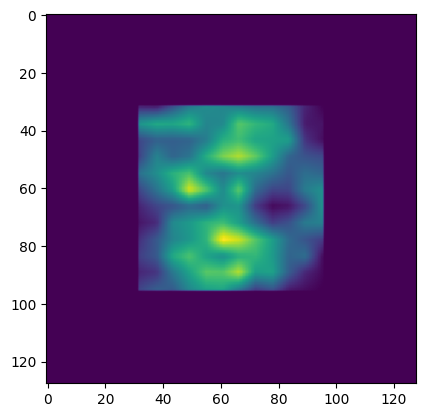

In [3]:
import matplotlib.pyplot as plt

plt.imshow(resized_pos_mri[:, :, 10])

In [4]:
import cv2

In [5]:
def find_brain_bounding_box(image):
    x, y, w, h = (image.shape[0] + 1, image.shape[1] + 1, -1, -1)
    for slice in image.T:
        blurred = cv2.GaussianBlur(slice.T, (13, 13), 150)
        blurred *= 255.0 / blurred.max()
        blurred[np.where(blurred < 0)] = 0
        blurred = blurred.astype(np.uint8)
        ret, thres = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        blurred_thres = cv2.medianBlur(thres, 5)
        contours, hierarchy = cv2.findContours(blurred_thres, 1, 2)
        curr_x, curr_y, curr_w, curr_h = cv2.boundingRect(contours[0])
        w = max(w, curr_x + curr_w)
        h = max(h, curr_y + curr_h)
        x = min(x, curr_x)
        y = min(y, curr_y)
    # provide a small padding around the found box:
    x = max(x - 10, 0)
    y = max(y - 10, 0)
    w = min(w + 10, image.shape[0])
    h = min(h + 10, image.shape[1])
    return x, y, w, h

In [6]:
def normalize(volume):
    """Normalize the volume"""
    volume = np.array(volume)
    min = volume.min()
    max = volume.max()
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

In [7]:
def resize_to_input_shape(img):
    shape = (128, 128)
    n_frames = 50
    # Starting index to extract the 50 central frames of the third dimension
    index = int(img.shape[2] / 2) - int(n_frames / 2)
    final_img = img[:, :, index: index + n_frames]
    x, y, w, h = find_brain_bounding_box(final_img)
    square_size = max(w - x, h - y)
    to_square = square_size - w + x, square_size - h + y
    miss_x, miss_y = to_square
    x, y = max(int(x - np.floor(miss_x / 2)), 0), max(int(np.floor(y - miss_y / 2)), 0)
    w, h = int(np.floor(w + miss_x / 2)), int(np.floor(h + miss_y / 2))
    return np.array(
        [
            #cv2.resize(frame, shape)
            cv2.resize(frame[x:w, y:h], shape)
            for frame in final_img.T
        ]
    ).T

In [8]:
from nilearn import plotting
import nibabel as nib

#template = load_mni152_template(resolution=2)
atlas = nib.load(basedir / "mri1.nii")

/Users/andrea/Library/Caches/pypoetry/virtualenvs/dementiadetection-mK5toDjQ-py3.9/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


(128, 128, 50)
(128, 128, 50)


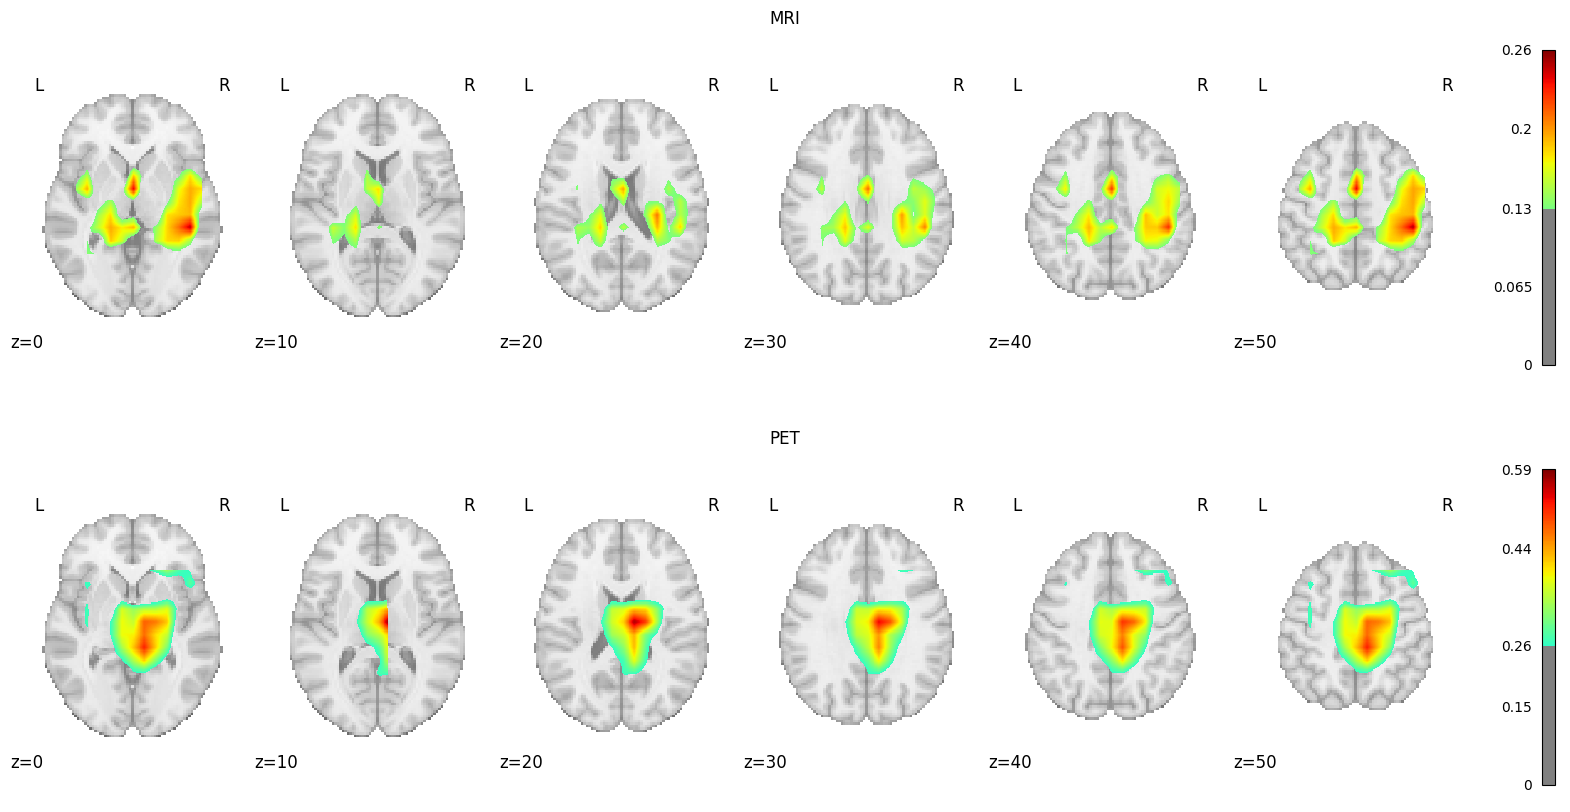

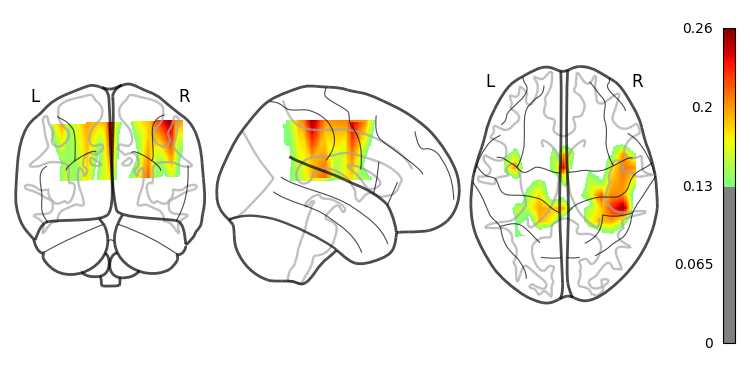

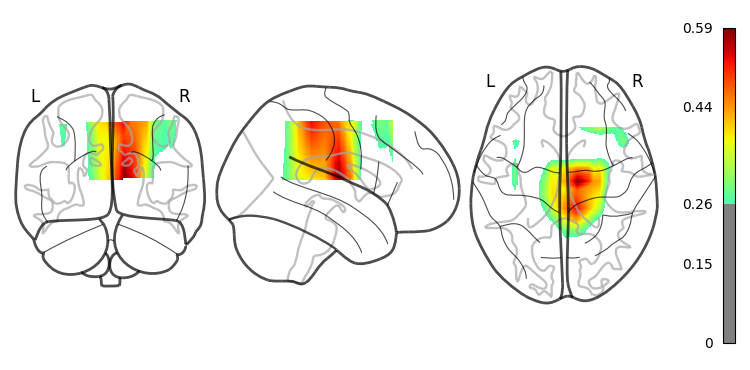

In [11]:

affine = np.array([[1.15, 0, 0, 17],
                   [0, 1.15, 0, -10],
                   [0, 0, 1.15, +134],
                   [0, 0, 0, 1]]).dot(atlas.affine)
affine = np.array([[.8, 0, 0, 17],
                   [0, .9, 0, -10],
                   [0, 0, 0.9, +134],
                   [0, 0, 0, 1]]).dot(atlas.affine)
fig, ax = plt.subplots(2,1, figsize=(20,10))
for gradcam, title,a in [(pos_mean_mri, 'MRI',ax[0]), (pos_mean_pet, 'PET', ax[1])]:
    #print(atlas.shape, gradcam.shape)
    print(gradcam.shape)
    nii = nib.Nifti2Image(gradcam, affine=affine)
    resized = resize_to_input_shape(normalize(atlas.get_fdata()))
    #atlas = atlas.get_fdata()
    #resampled_stat_img = resample_to_img(nii, template)
    #plotting.plot_glass_brain(resampled_stat_img)
    #resampled_stat_img = nii
    #resampled_stat_img = atlas.slicer[0:atlas.shape[2]-50,0:atlas.shape[2]-50,50:atlas.shape[2]-50]
    #plotting.plot_img(nib.Nifti2Image(atlas, affine=affine))
    plotting.plot_glass_brain(nii, display_mode='ortho', threshold="auto", cmap='jet',
                       cut_coords=range(0, 51, 10), colorbar=True).savefig(basedir / f"../{title.lower()}-glassbrain.pdf")
    plotting.plot_stat_map(nii, display_mode='z', threshold="auto", cmap='jet',
                       cut_coords=range(0, 51, 10), colorbar=True, axes=a)#.savefig(basedir / f"../{title.lower()}.pdf")
    a.set_title(f"{title}")
#plt.tight_layout()
fig.savefig("both.png", dpi=300, bbox_inches='tight')
plt.show()
    #plotting.plot_glass_brain(resampled_stat_img)

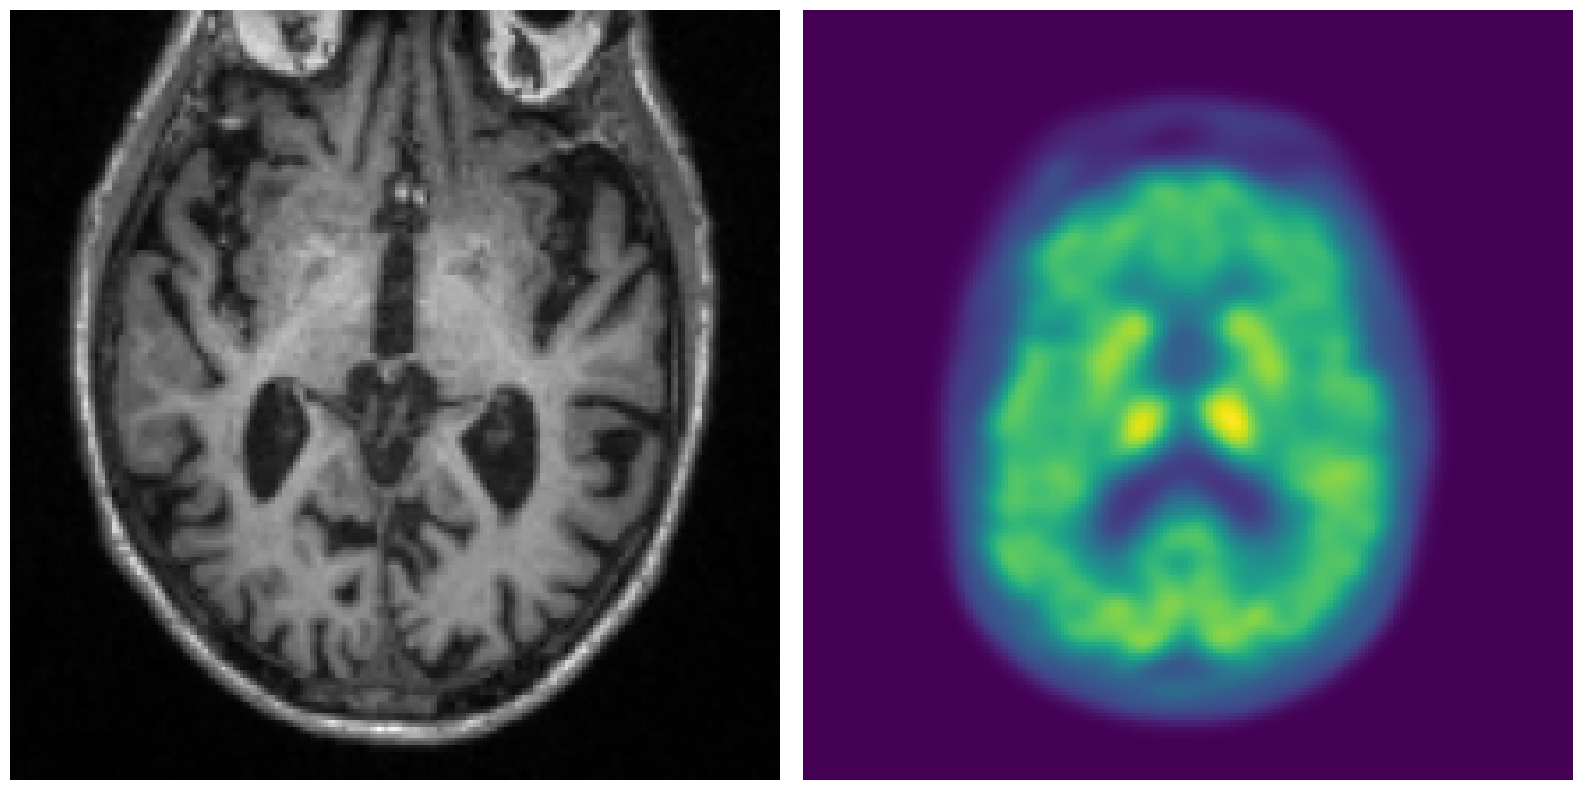

In [14]:
from PIL import Image

fig, ax = plt.subplots(1, 2, figsize=(16,8))

mri_sample = np.asarray(Image.open(basedir / "samples/mri-sample.png").rotate(90))
pet_sample = np.asarray(Image.open(basedir / "samples/pet-sample.png").rotate(-90))

ax[0].imshow(mri_sample)
ax[1].imshow(pet_sample)
for a, title in zip(ax, ["MRI", "PET"]):
    a.axis('off')
    #a.set_title(f"Example of {title} scan")
plt.tight_layout()
fig.savefig("samples.png", dpi=300, bbox_inches='tight')
plt.show()